In [62]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds as SVDS
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
import unidecode
import os

# nltk.download('punkt')
# nltk.download('machado')
# nltk.download('stopwords')
# nltk.download('rslp')

# %pip install spacy
# %spacy download pt


In [63]:
def calcula_pesos_sentimentos(rank,  sentimentos, WC,  U):
    WV = np.zeros((len(sentimentos.keys()), rank))
    for k, values in enumerate(sentimentos.values()):
        for value in values:
            pattern = re.compile(r'\b({})\b'.format(value))
            indexes = [e for e, inx in enumerate(
                WC.index.values) if pattern.search(inx)]
            if len(indexes) > 0:
                WV[k, :] += [U[index] for index in indexes][0]
    return WV / rank


def normalizar(x,  a,  b):
    return (2 * b) * (x - np.min(x)) / np.ptp(x) + a


In [64]:
def pre_processamento(texto):
    texto = texto.lower()
    documento = pln(texto)
    lista = []
    # tratamento de stopWords e pontuações
    pontuacao_stopwords = nltk.corpus.stopwords.words(
        "portuguese") + list(punctuation)
    # tratamento de stopwords sem acento.
    stopwords_sem_acento = [unidecode.unidecode(
        texto) for texto in pontuacao_stopwords]
    # Tokenização por pontuação
    for token in documento:
        if token.lower_ not in stopwords_sem_acento:
            lista.append(token.lemma_)
    return lista


def ler_arquivo_emocao(emocao, path='emocoes'):
    with open(f'{path}/{emocao}', 'r') as h:
        palavras = h.readlines()
        for i, palavra in enumerate(palavras):
            palavra = palavra.replace('\n', '').lower().strip()
            palavras[i] = ''.join(pre_processamento(palavra))
            # words[i] = [w.lemma_ for w in NLP(word, disable=['parser'])][0]
    return sorted(list(set(palavras)))


In [65]:
def plotar_grafico_area(pesos, categories, nome):
    categories = [*categories, categories[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)

    restaurant_1 = pesos
    restaurant_1 = [*restaurant_1, restaurant_1[0]]
    plt.plot(label_loc, restaurant_1)
    plt.title(nome, size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.savefig(nome + '.png', format='png')
    plt.show()



In [66]:
pln = spacy.load('pt_core_news_sm')
emocoes = {
    'ALEGRIA': ler_arquivo_emocao('alegria'),
    'DESGOSTO': ler_arquivo_emocao('desgosto'),
    'MEDO': ler_arquivo_emocao('medo'),
    'RAIVA': ler_arquivo_emocao('raiva'),
    'SURPRESA': ler_arquivo_emocao('surpresa'),
    'TRISTEZA': ler_arquivo_emocao('tristeza'),
}


In [67]:
machado_contos_data = [
    {
        'data': '1870',
        'nome': 'CONTOS FLUMINENSES',
        'caminho_livro_txt': 'obras\\conto\\1870_contosFluminenses.txt',
        'caminho_contos_txt': 'CONTOS\CONTOS_FLUMINENSES',


    },  {
        'data': '1873',
        'nome': 'HISTÓRIAS DA MEIA-NOITE',
        'caminho_livro_txt': 'obras\\conto\\1873_historiasMeiaNoite.txt',
        'caminho_contos_txt': 'CONTOS\HISTORIAS_DA_MEIA_NOITE',


    },  {
        'data': '1882',
        'nome': 'PAPÉIS AVULSOS',
        'caminho_livro_txt': 'obras\\conto\\1882_papeisAvulsos.txt',
        'caminho_contos_txt': 'CONTOS\PAPEIS_AVULSOS',


    },  {
        'data': '1884',
        'nome': 'HISTÓRIAS SEM DATA',
        'caminho_livro_txt': 'obras\\conto\\1884_historiasSemData.txt',
        'caminho_contos_txt': 'CONTOS\HISTORIAS_SEM_DATA',


    },  {
        'data': '1896',
        'nome': 'VÁRIAS HISTÓRIAS',
        'caminho_livro_txt': 'obras\\conto\\1896_variasHistorias.txt',
        'caminho_contos_txt': 'CONTOS\VARIAS_HISTORIAS',


    },  {
        'data': '1899',
        'nome': 'PÁGINAS RECOLHIDAS',
        'caminho_livro_txt': 'obras\\conto\\1899_paginasRecolhidas.txt',
        'caminho_contos_txt': 'CONTOS\PAGINAS_RECOLHIDAS',


    },  {
        'data': '1906',
        'nome': 'RELÍQUIAS DE CASA VELHA',
        'caminho_livro_txt': 'obras\\conto\\1906_reliquias.txt',
        'caminho_contos_txt': 'CONTOS\RELIQUIAS_DE_CASA_VELHA',

    }
]


def consultar_arquivos(item):
    dic_contos = {}
    path = item.get('caminho_contos_txt')
    for file in os.listdir(item.get('caminho_contos_txt')):
        if file.endswith(".txt"):
            file_path = f"{path}\{file}"
            with open(file_path, 'r', encoding="UTF-8") as f:
                dic_contos[file] = f.read()
    item['contos'] = dic_contos


for livro in machado_contos_data:
    with open(livro.get('caminho_livro_txt'), 'r', encoding="UTF-8") as f:
        livro['livro'] = f.read()
    consultar_arquivos(livro)


In [68]:

def calcula_pesos_contos(texto, emocoes, ):
    _vectorize = TfidfVectorizer()
    X = _vectorize.fit_transform(texto)
    pesos = pd.DataFrame(X.T.toarray(), index=_vectorize.get_feature_names())
    rank = 100
    np.random.seed(0)
    X2 = csc_matrix(pesos, dtype=np.float32)
    k = min(X2.shape)
    k = rank if k > rank else k - 1
    U, S, V = SVDS(X2, k=k)
    rank = max(min(U.shape), min(V.shape))
    lista_palavras = [w for i, w in enumerate(pesos.index)]
    for key, values in emocoes.items():
        emocoes[key] = [value for value in values if value in lista_palavras]

    WV = calcula_pesos_sentimentos(rank, emocoes, pesos, U)

    qttd_contos = len(texto)
    qttd_emocoes = len(emocoes.keys())
    dtframe = np.ones((qttd_contos + 2, qttd_emocoes))
    dtframe[-1, :] = np.tile([-1], qttd_emocoes)

    for k in range(qttd_emocoes):
        for i in range(qttd_contos):
            dtframe[i][k] = cosine_similarity([WV[k]], [V.T[i, :]])
            mmax, mmin = np.max(dtframe[i]), np.min(dtframe[i])
            if abs(mmin) > mmax:
                dtframe[i] = -dtframe[i]
    return np.round(normalizar(dtframe, 1, 100)[:-2], 2)


In [69]:
todos_livros = []
nome_todos_livros = []
for item in machado_contos_data:
    nome_todos_livros.append(item.get('nome'))
    todos_livros.append(item.get('livro'))
peso_livros = calcula_pesos_contos(todos_livros, emocoes)



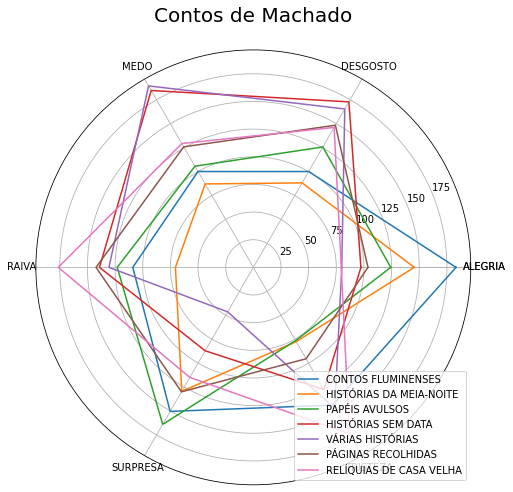

In [76]:
categories = list(emocoes.keys())
categories = [*categories, categories[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
for index in range(len(peso_livros)):
    restaurant_1 = peso_livros[index]
    restaurant_1 = [*restaurant_1, restaurant_1[0]]
    plt.plot(label_loc, restaurant_1, label=nome_todos_livros[index])
plt.title('Contos de Machado', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.savefig('ContosMachado.png', format='png')
plt.show()


In [ ]:
for index in range(len(peso_livros)):
    peso_do_livro = peso_livros[index]
    nome = nome_todos_livros[index]
   
    plotar_grafico_area(peso_do_livro, list(emocoes.keys()) ,nome)

In [83]:
def plotar_grafico_area_contos_livro(categories, pesos, nomes, titulo):
    categories = [*categories, categories[0]]


    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    for index in range(len(pesos)):
        restaurant_1 = pesos[index]
        restaurant_1 = [*restaurant_1, restaurant_1[0]]
        plt.plot(label_loc, restaurant_1, label=nomes[index])
    plt.title(titulo, size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.savefig(titulo +'_contos.png', format='png')
    plt.show()

In [ ]:
todos_contos = []
nome_contos = []
for item in machado_contos_data:
    contos = item.get('contos')
    contos_livro = []
    nome_contos_livro = []
    for conto in contos:
        contos_livro.append(contos.get(conto))
        nome_contos_livro.append(conto)
        todos_contos.append(contos.get(conto))
        nome_contos.append(conto)
    peso_contos_livro = calcula_pesos_contos(contos_livro, emocoes)
    plotar_grafico_area_contos_livro( list(emocoes.keys()),  peso_contos_livro, nome_contos_livro,item.get('nome'))
    for index in range(len(peso_contos_livro)):
        peso = peso_contos_livro[index]
        nome = nome_contos_livro[index]
        plotar_grafico_area(peso, list(emocoes.keys()) ,nome)
    
peso_contos = calcula_pesos_contos(todos_contos, emocoes)
plotar_grafico_area_contos_livro( list(emocoes.keys()),  peso_contos, nome_contos,'Contos de Machado de Assis')
